# Titanic Dataset Survival Prediction
The below is a short analysis of the Titanic data set available on Kaggle.com. There are two main goals of this analysis:
1. To create a simple logistic regression model to predict survival.
2. To assess how different methods of imputation of the `Age` variable affect model performance.

## Table of contents:
<ol type="I">
    <li><a href=#information-about-the-data>Information about the data</a></li>
    <li><a href=#data-dictionary>Data dictionary</a></li>
    <li><a href=#variable-notes>Variable notes</a></li>
    <li><a href=#analysis-start>Analysis start</a></li>
    <ol type='i'>
        <li><a href=#assess-for-missing-data-using-aeaborns-heatmap>Assess for missing data</a></li>
        <li><a href=#clean-the-data-set>Clean the data set</a></li>
        <li><a href=#reassess-missingness>Reassess missingness</a></li>
        <li><a href=#different-imputation-methods>Different imputation methods</a></li>
        <ol type="a">
            <li><a href=#simple-mean-imputation>Simple mean imputation</a></li>
            <li><a href=#imputation-by-mean-age-stratified-by-class>Imputation by mean age stratified by class</a></li>
            <li><a href=#knn-imputation>KNN imputation</a></li>
            <li><a href=#multivariate-feature-imputation>Multivariate feature imputation</a></li>
        </ol>
        <li><a href=#test-data-modification>Test data modification</a></li>
        <ol type='a'>
            <li><a href=#mean-imputation>Mean imputation</a></li>
            <li><a href=#class-stratified-imputation>Class-stratified imputation</a></li>
            <li><a href=#knn-imputation-test>KNN imputation</a></li>
            <li><a href=#tree-imputation>Tree imputation</a></li>
        </ol>
        <li><a href=#start-model-building>Start model building</a></li>
        <li><a href=#logistic-regression-models>Logistic regression models</a></li>
        <li><a href=#plot-learning-curves>Plot learning curves</a></li>
        <ol type='a'>
            <li><a href=#accuracy-based-learning-curve>Accuracy-based learning curve</a></li>
            <li><a href=#cost-based-learning-curve>Cost-based learning curve</a></li>
            <li><a href=#learning-curve-interpretation>Learning curve interpretation</a></li>
        </ol>
        <li><a href=#perform-feature-engineering>Perform feature engineering</a></li>
    </ol>
</ol>

Import the required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Generate inline figures.

In [3]:
%matplotlib inline

## Information about the data<a id="information-about-the-data"></a>

> The below text is adapted from the Kaggle Titanic Competition.

The data has been split into two groups:
- training set (`train.csv`)
- test set (`test.csv`)

The training will be used to build the below machine learning model. It contains the outcome information (also known as the “ground truth”) for each passenger. 

The test will be used to assess model performance. The test set does not include the ground truth for each passenger. The trained model will predict whether or not a passenger survived.

## Data dictionary<a id="data-dictionary"></a>  

| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

## Variable notes<a id="variable-notes"></a>

**pclass:** A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

**age:** 
- Fractional if less than 1. 
- If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way:
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way:
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Analysis start<a id="analysis-start"></a>

Read in the data.

In [4]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

Look at the data.

In [5]:
titanic_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
titanic_test.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### Assess for missing data using Seaborn's heatmap <a id="assess-for-missing-data-using-aeaborns-heatmap"></a>
The heatmap columns correspond to the columns of the training data set. By calling `.isnull()` on the `DataFrame`, a matrix of Boolean values is generated. This is then plotted with a heatmap showing missing data (below).

<AxesSubplot:>

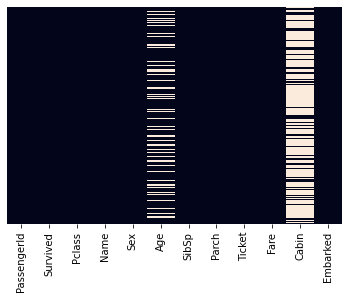

In [7]:
sns.heatmap(data=titanic_train.isnull(), yticklabels=False, cbar=False)

The above shows that the `Age` and `Cabin` columns have missing data. The proportion of missing data for each is:

In [8]:
age_proportion = sum(titanic_train['Age'].isnull()) / len(titanic_train['Age'])
cabin_proportion = sum(titanic_train['Cabin'].isnull()) / len(titanic_train['Cabin'])
print(" Age missing proportion: ", np.round(age_proportion, decimals=3), "\n",
      "Cabin missing proportion: ", np.round(cabin_proportion, decimals=3))

 Age missing proportion:  0.199 
 Cabin missing proportion:  0.771


There is a much larger proportion of missing cabin data than age data. The age missing proportion is amenable to filling in by imputation. Different imputation methods may change the performance of a trained algorithm. In order to assess these differences quickly and easily, we will start by training a simple logistic regression model as assessing its performance.

### Clean the data set<a id="clean-the-data-set"></a>

Remove columns that will not be used for training.

In [9]:
titanic_train_new = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
titanic_train_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


The `Pclass`, `Sex`, and `Embarked` columns are categorical variables that need to be modified with dummy variables in order to train the logistic regression model.

In [10]:
titanic_train_new1 = pd.get_dummies(data=titanic_train_new, columns=['Pclass','Sex','Embarked'], 
                                   drop_first=True)

In [11]:
titanic_train_new1['Pclass'] = titanic_train_new['Pclass']

### Reassess missingness<a id="reassess-missingness"></a>

<AxesSubplot:>

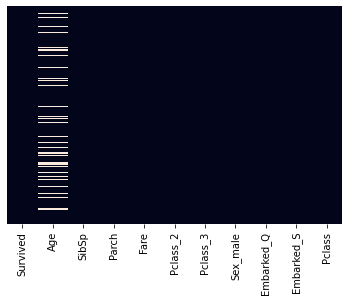

In [12]:
sns.heatmap(data=titanic_train_new1.isnull(), yticklabels=False, cbar=False)

### Different imputation methods<a id="different-imputation-methods"></a>

Three imputation methods will be used to generate three different data sets. Each of these subsequent data sets will then be used to train a model and predict on the held-out test data. Performance of the each model will be assessed to distinguish how each type of imputation affects model performance.

Imputations methods:  
1. [Simple mean imputation](#simple-mean-imputation)  
2. [Imputation by mean age stratified by class](#imputation-by-mean-age-stratified-by-class)  
4. [Nearest neighbors imputation&mdash;using `sklearn`](#knn-imputation)  
3. [Multivariate feature imputation&mdash;experimental `sklearn` feature](#multivariate-feature-imputation)  


Each imputation methods will have a different effect on the distribution of the original variable. This will be assessed using a simple histogram with an overlying kernel density estimate.

### Simple mean imputation<a id="simple-mean-imputation"></a>
Impute the age by inserting mean age.

Define a function to apply to the data frame.

In [13]:
def impute_mean(age):
    if np.isnan(age):
        return titanic_train_new1['Age'].mean()
    else:
        return age

Apply the mean imputation function.

In [14]:
titanic_train_new1['age_mean_imputed'] = titanic_train_new1['Age'].apply(impute_mean)

Plot the resulting imputation histogram.

Text(0.5, 1.0, 'Mean Age Imputation')

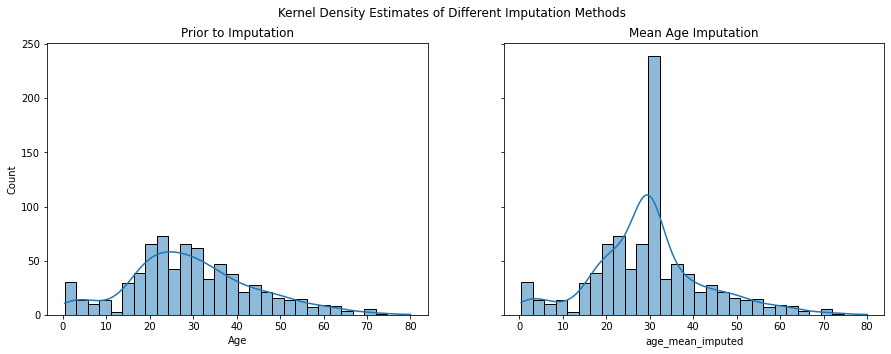

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_train_new1, x='age_mean_imputed', bins=30, kde=True)
axs[1].set_title('Mean Age Imputation')

The mean imputed age obviously has a large number of age values at the mean age of about 29 years old. This significantly modifies the distribution of the variable, but there are no longer any missing values:

In [16]:
sum(titanic_train_new1['age_mean_imputed'].isnull())

0

### Imputation by mean age stratified by class<a id="imputation-by-mean-age-stratified-by-class"></a>
The data can be stratified by passenger class. The mean age of each passenger class can the be used for a slightly more sophisticated method of imputation.

Define a function to impute the stratified mean age.

In [17]:
# compute the means for each pclass
pclass_1_mean = titanic_train_new1[titanic_train_new1['Pclass']==1]['Age'].mean()
pclass_2_mean = titanic_train_new1[titanic_train_new1['Pclass']==2]['Age'].mean()
pclass_3_mean = titanic_train_new1[titanic_train_new1['Pclass']==3]['Age'].mean()

# define the function to apply to the data frame
def strat_mean_impute(class_age):
    if np.isnan(class_age[1]):
        if class_age[0] == 1:
            return pclass_1_mean
        elif class_age[0] == 2:
            return pclass_2_mean
        else:
            return pclass_3_mean
    else:
        return class_age[1]

Apply the by-class imputation function.

In [18]:
titanic_train_new1['age_class_imputed'] = titanic_train_new1[['Pclass', 'Age']].apply(strat_mean_impute, axis=1)

Text(0.5, 1.0, 'Class-stratified Age Imputation')

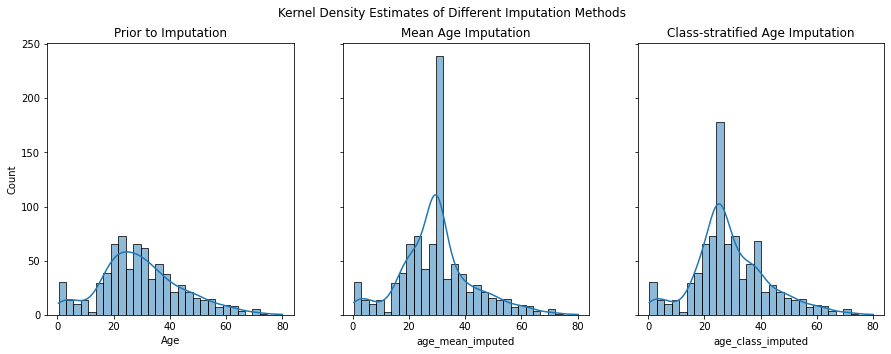

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_train_new1, x='age_mean_imputed', bins=30, kde=True)
axs[1].set_title('Mean Age Imputation')

sns.histplot(ax=axs[2], data=titanic_train_new1, x='age_class_imputed', bins=30, kde=True)
axs[2].set_title('Class-stratified Age Imputation')

In [20]:
# number of passengers in each class
titanic_train_new1['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [21]:
# number of missing values in the third class
sum(titanic_train_new1[titanic_train_new1['Pclass']==3]['Age'].isnull())

136

Though less pronounced, the class-stratified imputation of age still modifies the age distribution significantly. There is no longer as obvious a peak at the mean age, but because the majority of passengers were in 3rd class (n=491), there remains a large peak at the mean age of passengers in 3rd class as they also were the large majority of missing ages as well (n=136).

### KNN imputation<a id="knn-imputation"></a>

In [22]:
from sklearn.impute import KNNImputer

Instantiate the imputer.

In [23]:
knn_imputer = KNNImputer()

<a id='above'></a>Because the KNN imputer fits a model to predict the missing values, the data frame for imputation must be the original data. Moreover, because the test data has missing `Age` values as well, those missing values must also be imputed. Therefore, the `Survived` and `Pclass` column will be removed before imputation is performed. The categorical variables will remain "dummified" because that is how they will be included when imputing the test data as well.

In [24]:
titanic_knn_impute = titanic_train_new1[['Age', 'SibSp', 'Parch', 
                                        'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 
                                        'Embarked_Q', 'Embarked_S']].copy()

Generate an array of the data with the missing values filled in.

In [25]:
titanic_knn_imputed = knn_imputer.fit_transform(titanic_knn_impute)

Recreate the data frame.

In [26]:
titanic_knn_imputed = pd.DataFrame(titanic_knn_imputed, columns=titanic_knn_impute.columns)

Plot the age data.

Text(0.5, 1.0, 'KNN Age Imputation')

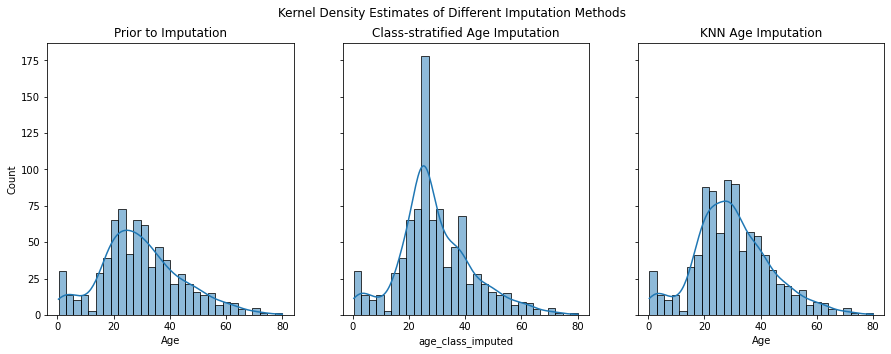

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_train_new1, x='age_class_imputed', bins=30, kde=True)
axs[1].set_title('Class-stratified Age Imputation')

sns.histplot(ax=axs[2], data=titanic_knn_imputed, x='Age', bins=30, kde=True)
axs[2].set_title('KNN Age Imputation')

### Multivariate feature imputation<a id="multivariate-feature-imputation"></a>
This is an experimental feature in `sklearn`. There are several options for the estimator to use in order to perform the imputation:
- **BayesianRidge:** regularized linear regression
- **DecisionTreeRegressor:** non-linear regression
- **ExtraTreesRegressor:** similar to missForest in R
- **KNeighborsRegressor:** comparable to other KNN imputation approaches

I am most familiar with the `missForest` package in `R`. Based on the <a href=https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py>documentation</a>, the `ExtraTreesRegressor` is most similar. Therefore, the below is performed using this method.

In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

As noted <a href=#above>above</a>, the data for the imputer must match the test data.

In [29]:
titanic_mv_impute = titanic_train_new1[['Age', 'SibSp', 'Parch', 
                                        'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 
                                        'Embarked_Q', 'Embarked_S']].copy()

Perform Extra Trees regression to fill in the missing values.

In [30]:
from sklearn.ensemble import ExtraTreesRegressor

Instantiate the imputer.

In [31]:
imp_tree = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=42))

Fit the Extra Trees Regressor on the missing data.

In [32]:
imp_tree.fit(X=titanic_mv_impute)

IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10,
                                               random_state=42))

Generate an array of the data with the missing values filled in.

In [33]:
titanic_tree_imputed = imp_tree.transform(X=titanic_mv_impute)

Recreate the data frame.

In [34]:
titanic_tree_imputed = pd.DataFrame(titanic_tree_imputed, columns=titanic_mv_impute.columns)

Plot the age data as above.

Text(0.5, 1.0, 'Tree Age Imputation')

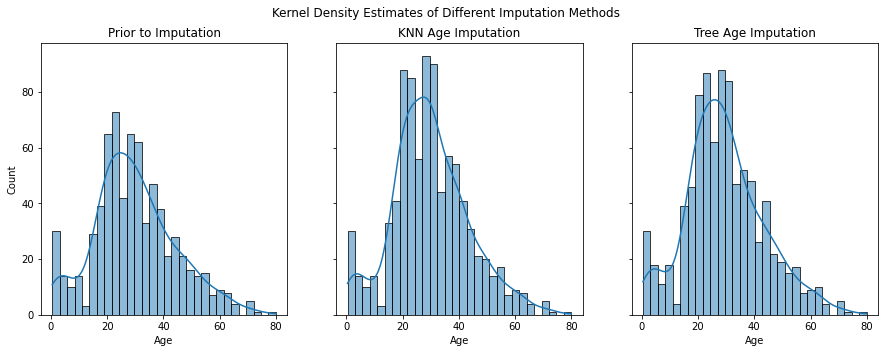

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_knn_imputed, x='Age', bins=30, kde=True)
axs[1].set_title('KNN Age Imputation')

sns.histplot(ax=axs[2], data=titanic_tree_imputed, x='Age', bins=30, kde=True)
axs[2].set_title('Tree Age Imputation')

It is clear by the above histograms and kernel density estimates that imputation using more sophisticated methods such as K-nearest neighbors or an ensemble tree-based method provides imputed values that are most consistent with the original data. The distribution of the tree-imputed ages is the most similar to that of the original data with missing values.

### Test data modification<a id='test-data-modification'></a>

In [36]:
titanic_test.drop(columns=['PassengerId','Name','Cabin','Ticket'], inplace=True)

In [37]:
titanic_test1 = pd.get_dummies(data=titanic_test, columns=['Embarked','Sex','Pclass'], drop_first=True)

Assess for missing data.

<AxesSubplot:>

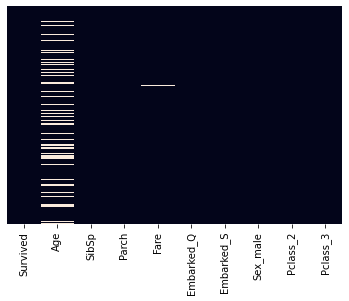

In [38]:
sns.heatmap(titanic_test1.isnull(), yticklabels=False, cbar=False)

The test data also&mdash;unsurprisingly&mdash;has a similar proportion of missing data for age. Therefore, in order to fit the below logistic regression models, the test data needs to be preprocessed in a similar manner. There will, then, be four different test data sets:
- A mean imputed data set
- A class-stratified mean imputed data set
- A KNN imputed data set
- A tree imputed data set

### Impute the missing test data using the four above methods

<AxesSubplot:xlabel='Age', ylabel='Count'>

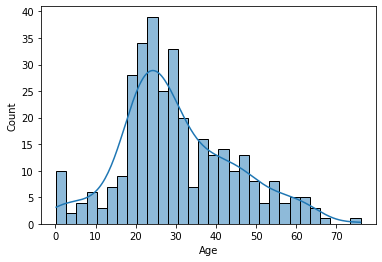

In [39]:
sns.histplot(data=titanic_test1, x='Age', bins=30, kde=True)

#### Mean imputation <a id='mean-imputation'></a>
Import the simple imputer to avoid creating another new function to impute the mean. This will also impute the mean fare for the one missing `Fare` value noted above.

In [40]:
from sklearn.impute import SimpleImputer

In [41]:
imp_mean = SimpleImputer(strategy='mean')

Impute missing data using the mean age.

In [42]:
titanic_test1_mean = pd.DataFrame(imp_mean.fit_transform(X=titanic_test1), columns=np.array(titanic_test1.columns))

Plot the age data.

Text(0.5, 1.0, 'Mean Age Imputation')

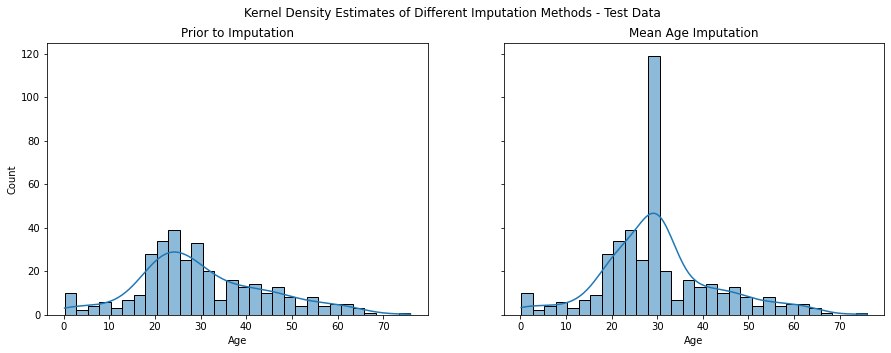

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods - Test Data')

sns.histplot(ax=axs[0], data=titanic_test1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_test1_mean, x='Age', bins=30, kde=True)
axs[1].set_title('Mean Age Imputation')

#### Class-stratified imputation <a id='class-stratified-imputation'></a>

First, impute the only missing `Fare` value using the same class-stratified method.

In [44]:
titanic_test1_class = titanic_test1.copy()

In [45]:
# find the missing fare value
titanic_test1[np.isnan(titanic_test1['Fare'])]

,Survived,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
152,0,60.5,0,0,NaN,0,1,1,0,1


In [46]:
# the missing fare value has a passenger class of 3
# compute the mean fare for class 3 passengers and substitute the missing value
mean_class3_fare = titanic_test1[titanic_test['Pclass']==3]['Fare'].mean()
titanic_test1_class.loc[152, 'Fare'] = mean_class3_fare

In [47]:
# compute the means for each pclass
pclass_1_mean = titanic_test1[titanic_test['Pclass']==1]['Age'].mean()
pclass_2_mean = titanic_test1[titanic_test['Pclass']==2]['Age'].mean()
pclass_3_mean = titanic_test1[titanic_test['Pclass']==3]['Age'].mean()

# define the function to apply to the data frame
def strat_mean_impute(class_age):
    if np.isnan(class_age[1]):
        if class_age[0] == 1:
            return pclass_1_mean
        elif class_age[0] == 2:
            return pclass_2_mean
        else:
            return pclass_3_mean
    else:
        return class_age[1]

Add the `Pclass` column back to perform the imputation.

In [48]:
titanic_test1_class['Pclass'] = titanic_test['Pclass']

Impute the class-stratified ages.

In [49]:
titanic_test1_class['Age'] = titanic_test1_class[['Pclass', 'Age']].apply(strat_mean_impute, axis=1)

Plot the histograms.

Text(0.5, 1.0, 'Class-stratified Age Imputation')

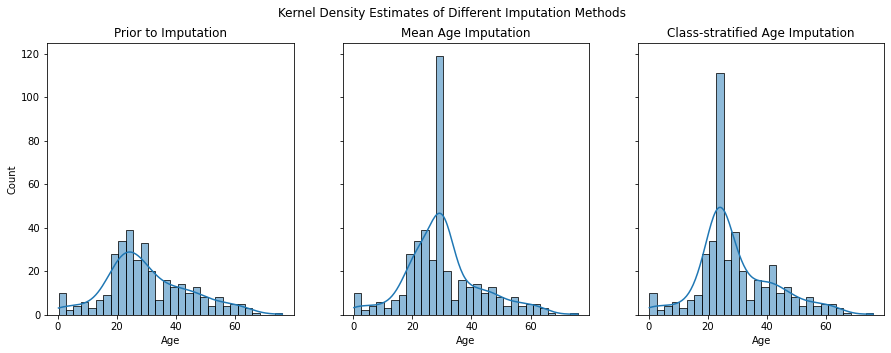

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_test1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_test1_mean, x='Age', bins=30, kde=True)
axs[1].set_title('Mean Age Imputation')

sns.histplot(ax=axs[2], data=titanic_test1_class, x='Age', bins=30, kde=True)
axs[2].set_title('Class-stratified Age Imputation')

#### KNN imputation <a id='knn-imputation-test'></a>

In [51]:
titanic_test1.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,34.5,0,0,7.8292,1,0,1,0,1
1,1,47.0,1,0,7.0000,0,1,0,0,1
2,0,62.0,0,0,9.6875,1,0,1,1,0
3,0,27.0,0,0,8.6625,0,1,1,0,1
4,1,22.0,1,1,12.2875,0,1,0,0,1


Instantiate the imputer and impute the data.

In [52]:
knn_imputer = KNNImputer()
titanic_test1_knn = knn_imputer.fit_transform(titanic_test1)

In [53]:
titanic_test1_knn = pd.DataFrame(titanic_test1_knn, columns=titanic_test1.columns)

Text(0.5, 1.0, 'KNN Age Imputation')

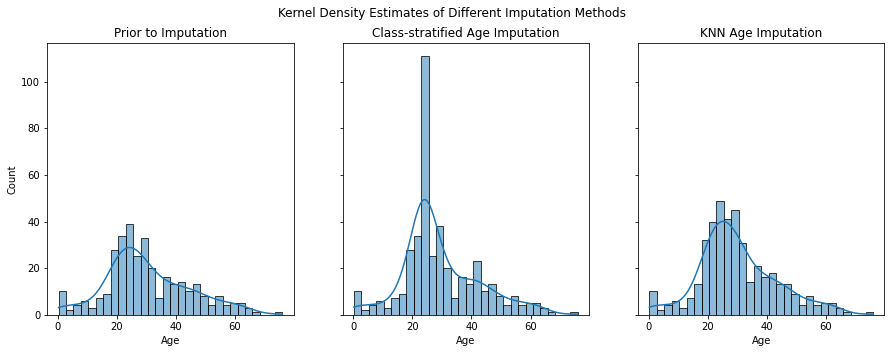

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_test1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_test1_class, x='Age', bins=30, kde=True)
axs[1].set_title('Class-stratified Age Imputation')

sns.histplot(ax=axs[2], data=titanic_test1_knn, x='Age', bins=30, kde=True)
axs[2].set_title('KNN Age Imputation')

#### Tree imputation <a id='tree-imputation'></a>

Instantiate the imputer and impute the data.

In [55]:
imp_tree = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=42))
titanic_test1_tree = imp_tree.fit_transform(X=titanic_test1)

In [56]:
titanic_test1_tree = pd.DataFrame(titanic_test1_tree, columns=titanic_test1.columns)

Text(0.5, 1.0, 'Tree Age Imputation')

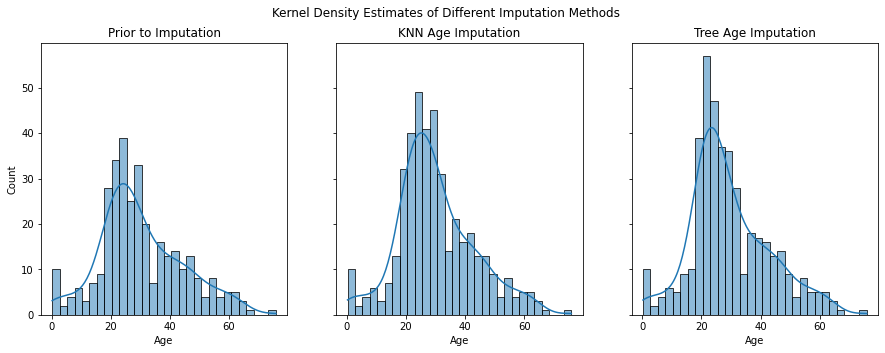

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_test1, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_test1_knn, x='Age', bins=30, kde=True)
axs[1].set_title('KNN Age Imputation')

sns.histplot(ax=axs[2], data=titanic_test1_tree, x='Age', bins=30, kde=True)
axs[2].set_title('Tree Age Imputation')

The tree-based imputation appears to maintain the bin count ratios more similar than the KNN-based imputation.

Reassess the missingness.

Original data:

<AxesSubplot:>

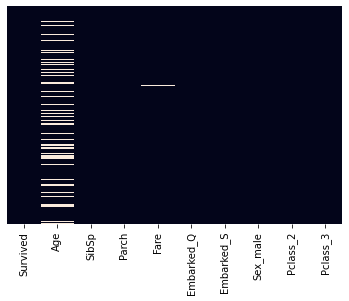

In [58]:
sns.heatmap(data=titanic_test1.isnull(), yticklabels=False, cbar=False)

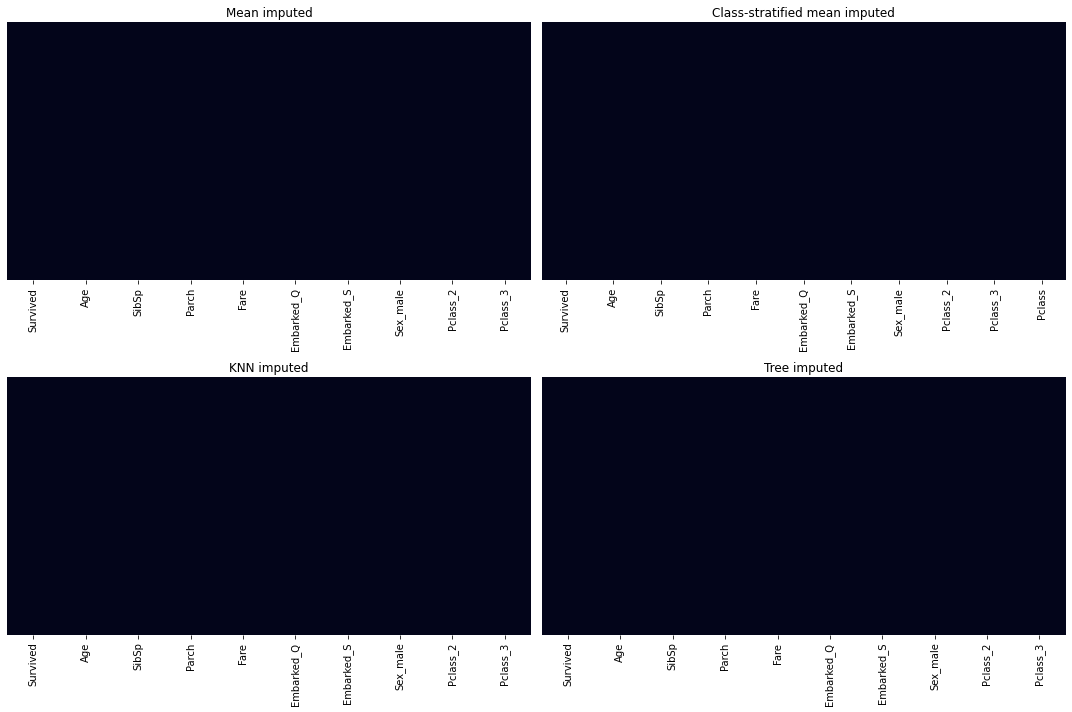

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharey=True)

sns.heatmap(ax=axs[0][0], data=titanic_test1_mean.isnull(), yticklabels=False, cbar=False)
axs[0][0].set_title('Mean imputed')

sns.heatmap(ax=axs[0][1], data=titanic_test1_class.isnull(), yticklabels=False, cbar=False)
axs[0][1].set_title('Class-stratified mean imputed')

sns.heatmap(ax=axs[1][0], data=titanic_test1_knn.isnull(), yticklabels=False, cbar=False)
axs[1][0].set_title('KNN imputed')

sns.heatmap(ax=axs[1][1], data=titanic_test1_tree.isnull(), yticklabels=False, cbar=False)
axs[1][1].set_title('Tree imputed')

plt.tight_layout()

Modify the test data frames to match the training data frames.

In [82]:
titanic_test1_mean = titanic_test1_mean[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 
                                         'Sex_male', 'Embarked_Q', 'Embarked_S']]

titanic_test1_class = titanic_test1_class[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 
                                           'Sex_male', 'Embarked_Q', 'Embarked_S']]

titanic_test1_knn = titanic_test1_knn[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 
                                       'Sex_male', 'Embarked_Q', 'Embarked_S']]

titanic_test1_tree = titanic_test1_tree[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 
                                         'Sex_male', 'Embarked_Q', 'Embarked_S']]

Create two data sets of mean imputed and class-stratified mean imputed Age columns that mirror the other training data frames.

In [60]:
titanic_mean_imputed = titanic_train_new1[['age_mean_imputed', 'SibSp', 'Parch', 'Fare', 
                                           'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 
                                           'Embarked_S']].copy()
titanic_mean_imputed.rename(columns={'age_mean_imputed':'Age'}, inplace=True)

In [61]:
titanic_class_imputed = titanic_train_new1[['age_class_imputed', 'SibSp', 'Parch', 'Fare', 
                                            'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 
                                            'Embarked_S']].copy()
titanic_class_imputed.rename(columns={'age_class_imputed':'Age'}, inplace=True)

All the missing values in the train and test data sets have been imputed using four methods.  

| Imputation method           | Train data set name   | Test data set name  |
|-----------------------------|-----------------------|---------------------|
| Mean value                  | titanic_mean_imputed  | titanic_test1_mean  |
| Class-stratified mean value | titanic_class_imputed | titanic_test1_class |
| KNN                         | titanic_knn_imputed   | titanic_test1_knn   |
| ExtraTreesRegressor         | titanic_tree_imputed  | titanic_test1_tree  |

### Start model building<a id="start-model-building"></a>

As a reminder, these are the train and test data set names:  

| Imputation method           | Train data set name   | Test data set name  |
|-----------------------------|-----------------------|---------------------|
| Mean value                  | titanic_mean_imputed  | titanic_test1_mean  |
| Class-stratified mean value | titanic_class_imputed | titanic_test1_class |
| KNN                         | titanic_knn_imputed   | titanic_test1_knn   |
| ExtraTreesRegressor         | titanic_tree_imputed  | titanic_test1_tree  |

### Logistic regression models<a id=logistic-regression-models></a>
Import logistic regression.

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
# get the y values
train_target_values = titanic_train['Survived']
test_true_values = titanic_test['Survived']

Create a function to train the logistic regression model on train and test data.

In [123]:
# solver = 'sag', max_iter=10000
def run_log_reg(train_features, train_target, test_features, test_true, solver, max_iter, 
                penalty, C=1):
    
    # instantiate the logistic regression model
    log_model = LogisticRegression(solver=solver, max_iter=max_iter, C=C, penalty=penalty)

    # fit the model
    log_model.fit(X=train_features, y=train_target)

    # make the predictions on the fitted model
    predictions = log_model.predict(X=test_features)

    # print the classification report
    return print(classification_report(y_true=test_true, y_pred=predictions))

Run the logistic regression model on the mean imputed train and test data.

In [124]:
run_log_reg(train_features=titanic_mean_imputed, train_target=train_target_values, 
            test_features=titanic_test1_mean, test_true=test_true_values,
            solver='newton-cg', max_iter=100, penalty='none')

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       260
           1       0.70      0.68      0.69       158

    accuracy                           0.77       418
   macro avg       0.76      0.75      0.75       418
weighted avg       0.77      0.77      0.77       418



Run the logistic regression model on the class-stratified mean imputed train and test data.

In [125]:
run_log_reg(train_features=titanic_class_imputed, train_target=train_target_values, 
            test_features=titanic_test1_class, test_true=test_true_values,
            solver='newton-cg', max_iter=100, penalty='none')

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       260
           1       0.70      0.68      0.69       158

    accuracy                           0.77       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.77      0.77       418



Run the logistic regression model on the KNN imputed train and test data.

In [126]:
run_log_reg(train_features=titanic_knn_imputed, train_target=train_target_values, 
            test_features=titanic_test1_knn, test_true=test_true_values,
            solver='newton-cg', max_iter=100, penalty='none')

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       260
           1       0.69      0.68      0.69       158

    accuracy                           0.77       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.76      0.77      0.76       418



Run the logistic regression model on the tree imputed train and test data.

In [127]:
run_log_reg(train_features=titanic_tree_imputed, train_target=train_target_values, 
            test_features=titanic_test1_tree, test_true=test_true_values,
            solver='newton-cg', max_iter=100, penalty='none')

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       260
           1       0.69      0.68      0.68       158

    accuracy                           0.76       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.76      0.76      0.76       418



It appears that different forms of imputation do not affect performance of the logistic regression model.

### Plot learning curves <a id='plot-learning-curves'></a>

In [128]:
from sklearn.model_selection import learning_curve

Using the `learning_curve` function, split the training data (`titanic_tree_imputed`) into training sets with an increasing number of the training examples, $m$ (`train_sizes`) and train the logistic regression model (the `estimator`) on a successively increasing number of training examples. The training and test scores (the `score` method of the given `estimator`&mdash;in this case logistic regression) reports a score of mean accuracy.  

The function then reports the `train_scores` and `test_scores`&mdash;two matrices where the columns are the training scores for each fold of the cross-validation sets and the rows are the scores for each batch of the training set splits as defined by `train_sizes`.  

The y-axis of learning curves can be many metrics. Traditionally, cost (or loss) is ploted as a function of the number of training examples. However, the accuracy (as below), F1 score, $R^2$, etc. can also be plotted with similar results and method of interpretation.

#### Accuracy-based learning curve <a id='accuracy-based-learning-curve'></a>

In [142]:
train_sizes, train_scores, test_scores = learning_curve(
        estimator=LogisticRegression(solver='newton-cg', max_iter=100, penalty='none'),
        X=titanic_tree_imputed,
        y=train_target_values,
        cv=None,
        n_jobs=None,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times=False
    )

Once the function runs, the mean and standard deviation of the scores from the (in this case default 5-fold) cross-validation folds is calculated to generate the data for the figure below.

In [143]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

Plot the figure.

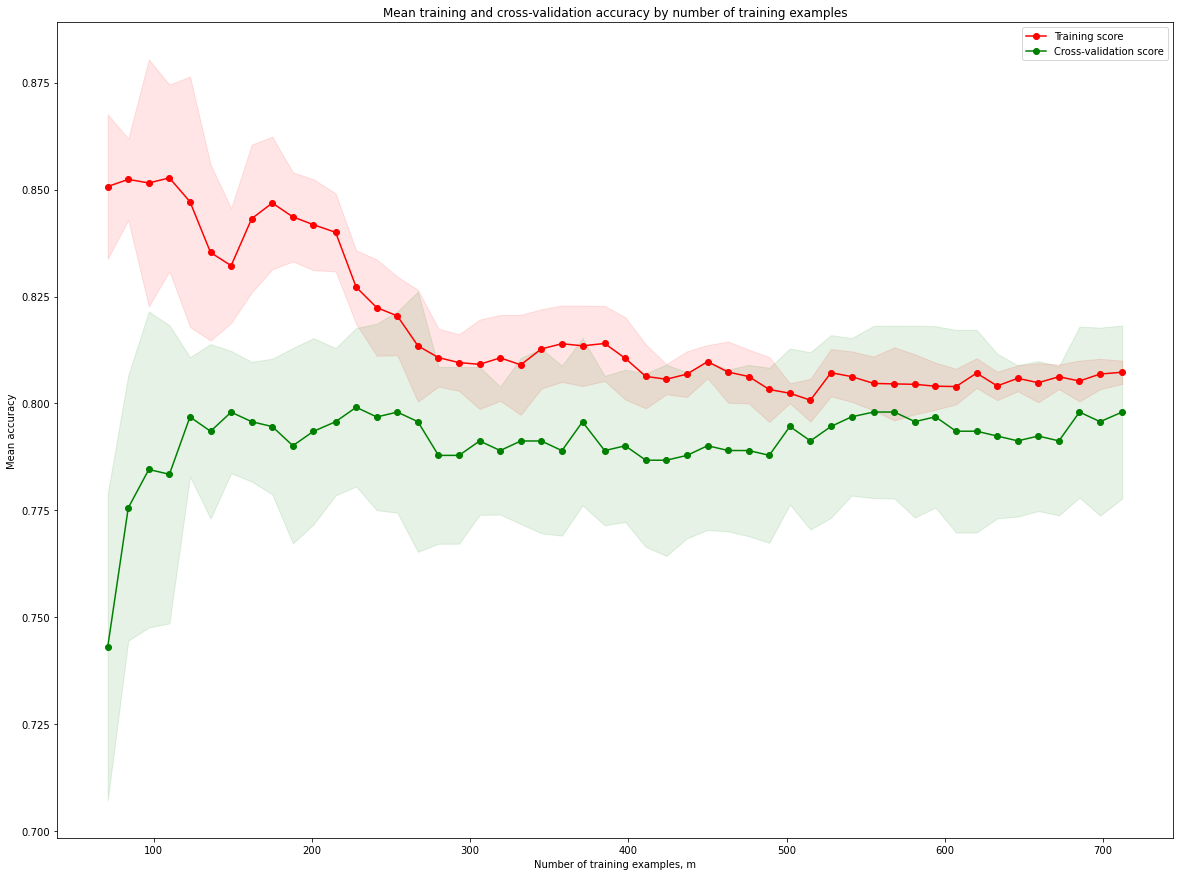

In [144]:
fig, ax = plt.subplots(figsize=(20, 15))

# show the standard deviation error bars for the training error
ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)

# show the standard deviation error bars for the testing error
ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)

# plot the scores
ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

# label the plot
ax.set_title('Mean training and cross-validation accuracy by number of training examples')
ax.set_ylabel('Mean accuracy')
ax.set_xlabel('Number of training examples, m')

# set the legend location
ax.legend(loc="best")

#### Cost-based learning curve <a id='cost-based-learning-curve'></a>

A more traditional learning curve with the y-axis measuring the value of the cost function can also be generated using the `learning_curve` function. As this model is a logistic regression model, the negative log loss is the cost function that is used. By setting the `score` parameter in the `learning_curve` function to `'neg_log_loss'`, the function outputs the training and crossvalidation loss (i.e., cost) rather than the mean accuracy "score".  

Performing the same steps as above:

In [150]:
train_sizes, train_loss, test_loss = learning_curve(
        estimator=LogisticRegression(solver='newton-cg', max_iter=100, penalty='none'),
        X=titanic_tree_imputed,
        y=train_target_values,
        scoring='neg_log_loss',
        cv=None,
        n_jobs=None,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times=False
    )

In [151]:
train_loss_mean = np.mean(train_loss, axis=1)
train_loss_std = np.std(train_loss, axis=1)
test_loss_mean = np.mean(test_loss, axis=1)
test_loss_std = np.std(test_loss, axis=1)

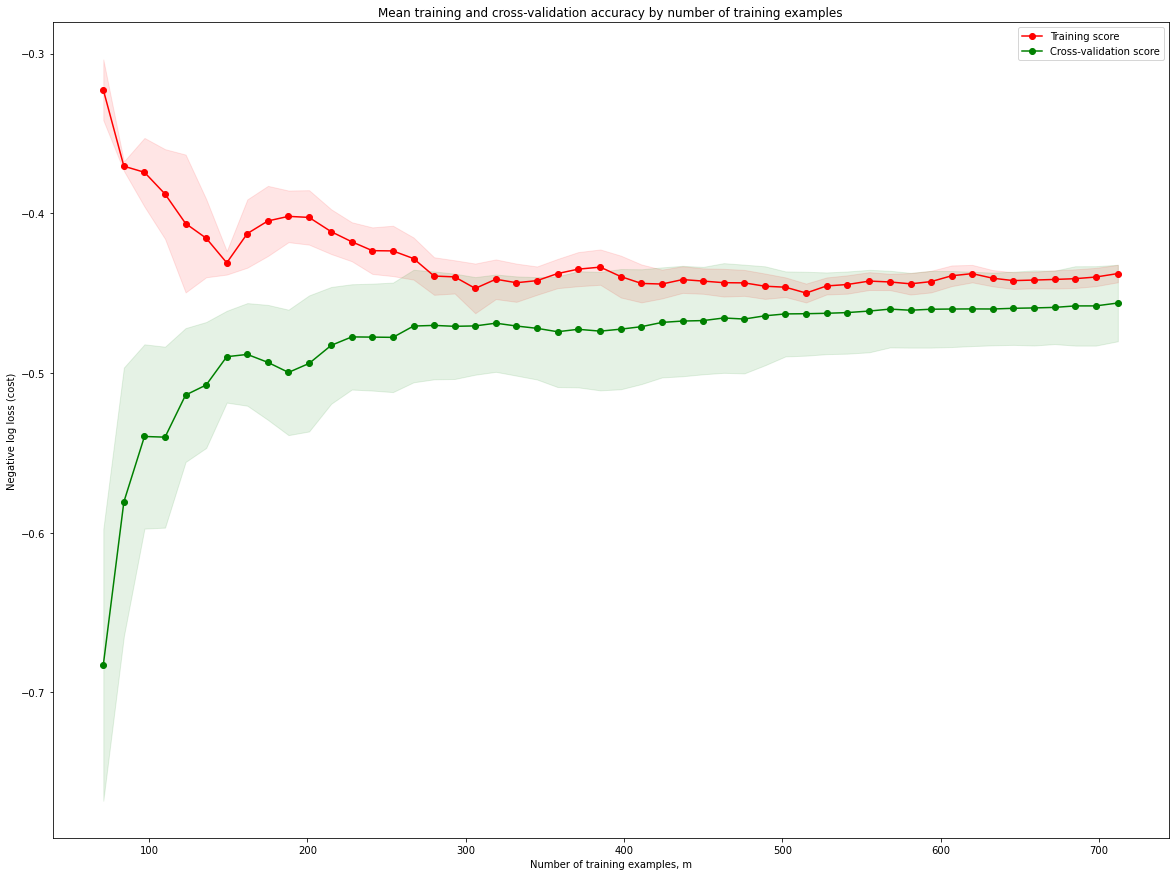

In [152]:
fig, ax = plt.subplots(figsize=(20, 15))

# show the standard deviation error bars for the training error
ax.fill_between(
    train_sizes,
    train_loss_mean - train_loss_std,
    train_loss_mean + train_loss_std,
    alpha=0.1,
    color="r",
)

# show the standard deviation error bars for the testing error
ax.fill_between(
    train_sizes,
    test_loss_mean - test_loss_std,
    test_loss_mean + test_loss_std,
    alpha=0.1,
    color="g",
)

# plot the errors
ax.plot(train_sizes, train_loss_mean, "o-", color="r", label="Training score")
ax.plot(train_sizes, test_loss_mean, "o-", color="g", label="Cross-validation score")

# label the plot
ax.set_title('Mean training and cross-validation accuracy by number of training examples')
ax.set_ylabel('Negative log loss (cost)')
ax.set_xlabel('Number of training examples, m')

# set the legend location
ax.legend(loc="best")

#### Learning curve interpretation <a id='learning-curve-interpretation'></a>

Based on the above learning curves, the model, as it stands, has high bias. That is, as the number of training examples increases above around 300, there is no improvement in the crossvalidation score. The training score approximates the crossvalidation score.

The typical steps used to improve models with high bias are:
- Get more features&mdash;feature engineering in order to capture more variance in the data set
- Decrease regularization&mdash;the logistic regression model was trained without regularization
- Add features using feature engineering&mdash;such as adding polynomial features in linear regression  

In this case, regularization cannot be changed and more features cannot be engineered. Therefore, the only way to increase the variance of the model is to engineer more features.

### Perform feature engineering <a id='perform-feature-engineering'></a>
To increase the variance of the model and hopefully improve the performace, new features must be added to the logistic regression model as diagnosed by the learning curves above. 